In [1]:
import torch
import numpy as np
import pandas as pd
import os
from pathlib import Path
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
path

Path('/home/jupyter/.fastai/data/mnist_sample')

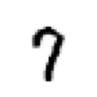

In [12]:
im7 = Image.open(path/'train'/'7'/'1975.png')
show_image(im7);

In [17]:
im7_t = tensor(im7)

In [20]:
im7_t[:18,:18]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,  13, 123, 249, 250,  64,   5,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 181, 253, 253, 253, 254, 253, 169,   9],
        [  0,   0,   0,   0,   0,   0,   0,   0,   9, 156, 253, 253, 238, 217, 220, 253, 253, 189],
        [  0,   0,   0,   0,   0,   0,   0,   0, 142, 253, 253, 235,  59,   0,   5,  84, 166, 253],


In [80]:
# now we create a kernel. normally these are initialized with random numbers and then SGD used to optimize
# based on supervised labels.
# in this case, let's create a horizontal edge detector manually.

# see the 18x18 preview above. our horizontal edge should pick up row index 7, the very top of the 7, but 
#not the row above it or below it.

top_edge = tensor([[ -1, -1, -1],
                   [  0,  0,  0],
                   [  1,  1,  1]]).float()

# the reason that manual kernel works: row index 8 will return positive values, row index 6 is all zeros 
# so nothing will be substracted.

# applying the kernel to the top left of the image looks like so:
result = im7_t[:3, :3] * top_edge
print('cell-wise multiplication (top-left 3x3): \n', result)
result = result.sum()
print('sum (top-left 3x3):', result)

# now create a helper function for that dot product...
def apply_kernel(layer, row, col, kernel):
    # apply the 3x3 kernel centered at position (row, col) of the input layer
    # this will not work on the edges of the input layer (index error)
    return (layer[row-1:row+2, col-1:col+2] * kernel).sum()

# for idx (7, 7) this should return 9 (look at the tensor output above to confirm intuition)
print('apply_kernel applied to (7,7) should return 9:', apply_kernel(im7_t, 7, 7, top_edge))

cell-wise multiplication (top-left 3x3): 
 tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])
sum (top-left 3x3): tensor(0.)
apply_kernel applied to (7,7) should return 9: tensor(9.)


## convolution, relu, maxpool, dense layer

kernel applied to entire image: 
 tensor([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.,   18.,  141.,  385.,  622.,  563.,  319.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,   42.,  223.,  476.,  687.,  759.,  760.,  760.,  676.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    9.,  165.,  413.,  644.,  603.,  323.,   53.,  127.,  407.],
        [   0.,    0.,    0.,    0.,    0.,    0.,  142.,  353.,  425.,  265., -140., -465., -696., -671., -421.],
        [   0.,    0.,    0.,    0.,    0.,   

<AxesSubplot:title={'center':'with relu'}>

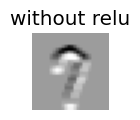

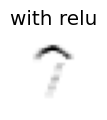

In [81]:
# now let's loop over the entire image and apply the kernel everywhere we can (discard edges)
idx = range(1, 27)
im7_t_top_edge = tensor([[apply_kernel(im7_t, row, col, top_edge) for col in idx] for row in idx])

# when I first did this the image was flipped along the diagonal because i had done the list comprehension backwards!
# beware careless mistakes!
print('kernel applied to entire image: \n', im7_t_top_edge[:15,:15])
show_image(im7_t_top_edge, title='without relu')

# and finally let's add a minimum with zero - we don't want negative activations.
im7_t_top_edge_relu = F.relu(im7_t_top_edge)
show_image(im7_t_top_edge_relu, title='with relu')

apply_maxpool applied to (5,5) should return 9: tensor(9.)
maxpool applied to entire image: 
 tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  42., 476., 759., 760., 676., 178.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 353., 644., 603., 127., 626., 599., 355.,   0.,   0.,   0.],
        [  0.,   0.,   0., 270., 270.,   0.,   0.,   0., 435., 371.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., 128., 252., 178.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., 125., 143.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., 304., 283.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0., 144., 190., 116.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0., 224., 224.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,

<AxesSubplot:title={'center':'after maxpool'}>

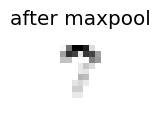

In [82]:
# now let's apply maxpooling.
def apply_maxpool(layer, row, col):
    return layer[row:row+2, col:col+2].max()

print('apply_maxpool applied to (5,5) should return 9:', apply_maxpool(im7_t_top_edge_relu, 5, 5))

# let's apply to entire image.
# here we skip every other index
idx = range(0, im7_t_top_edge_relu.size(0), 2)
im7_t_top_edge_relu_maxpool = tensor([[apply_maxpool(im7_t_top_edge_relu, row, col) for col in idx] for row in idx])

print('maxpool applied to entire image: \n', im7_t_top_edge_relu_maxpool)
show_image(im7_t_top_edge_relu_maxpool, title='after maxpool')

tensor([[-0.7124, -0.3564,  0.6990,  0.9557, -0.6004, -0.5550,  0.1238,  0.3931, -0.1629, -0.3123, -0.6568,  0.4269,  0.9798],
        [-0.4841,  0.4717,  0.4884,  0.8038, -0.1139,  0.0315,  0.7347,  0.6321,  0.9877, -0.2866,  0.3957,  0.6983, -0.6788],
        [ 0.1987, -0.2238,  0.6428, -0.4491,  0.0701,  0.5983, -0.9161, -0.8444, -0.5122,  0.6414,  0.6705, -0.6830,  0.1907],
        [-0.5299, -0.4642,  0.8624,  0.4830, -0.2735,  0.1472,  0.1938,  0.2342, -0.3423, -0.5889,  0.6621,  0.1344,  0.4185],
        [-0.3787,  0.4844,  0.7278,  0.6082,  0.2719,  0.9839, -0.0022,  0.2129,  0.9501,  0.9719, -0.4222,  0.9008,  0.3691],
        [-0.1119,  0.8731, -0.5180,  0.6497,  0.9909, -0.6897, -0.5901, -0.9909, -0.1800, -0.9082, -0.3349,  0.3036,  0.7069],
        [ 0.5570,  0.5551,  0.4149, -0.6202, -0.7940,  0.0415,  0.9496,  0.0563, -0.0860, -0.6787, -0.4958, -0.7709,  0.8007],
        [-0.1629, -0.8834,  0.1073,  0.0726, -0.1235,  0.3580,  0.5378, -0.9404, -0.7661, -0.0480, -0.9271, -0.

In [118]:
# let's create a dense layer with initial random weights in the internal [1,1)
dense_layer = torch.rand(im7_t_top_edge_relu_maxpool.size())*2 - 1

activation = F.relu((im7_t_top_edge_relu_maxpool*dense_layer).sum())

print('final activation:', activation)

# now assuming we had multiple activations, we would softmax them and take the argmax for our predicted label

final activation: tensor(1143.4187)


# stride convolution, average pooling

kernel applied to entire image: 
 tensor([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    5.,  141.,  622.,  319.,    5.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    9.,  413.,  603.,   53.,  407.,  499.,   62.,    0.,    0.,    0.],
        [   0.,    0.,    0.,  173.,  270., -335., -675., -689.,   39.,  371.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0., -120.,    0.,  218.,  178., -160.,    0.,    0.,    0.],
        [   0.,    0.,    0., -182., -688., -289.,    0.,  143., -143., -201.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,   82.,  192., -124.,  -72.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,  190.,  116., -255.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,  224.,

<AxesSubplot:title={'center':'stride with relu'}>

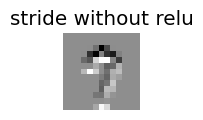

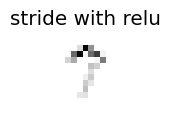

In [87]:
# let's try the same thing with a different technique
idx = range(1, 27, 2)
im7_t_top_edge_stride = tensor([[apply_kernel(im7_t, row, col, top_edge) for col in idx] for row in idx])

print('kernel applied to entire image: \n', im7_t_top_edge_stride)
show_image(im7_t_top_edge_stride, title='stride without relu')

# and finally let's add a minimum with zero - we don't want negative activations.
im7_t_top_edge_stride_relu = F.relu(im7_t_top_edge_stride)
show_image(im7_t_top_edge_stride_relu, title='stride with relu')

current size: torch.Size([13, 13])
kernel applied to entire image: 
 tensor([[   0.,    5.,  768.,  946.,    5.,    0.],
        [   0.,  438., -498., -907.,  405.,    0.],
        [   0., -443., -270.,  104., -410.,    0.],
        [   0.,    0.,  190.,  163.,    0.,    0.],
        [   0.,    0.,   41., -185.,    0.,    0.],
        [   0.,    0., -231., -121.,    0.,    0.]])


<AxesSubplot:title={'center':'layer 1: stride+relu\nlayer 2: stride+relu'}>

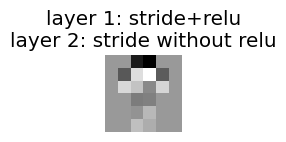

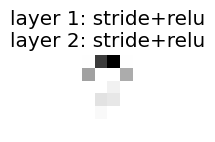

In [131]:
# let's apply it till we get down to a 7x7
print('current size:', im7_t_top_edge_stride_relu.size())

idx = range(1, im7_t_top_edge_stride_relu.size(0), 2)
im7_t_top_edge_stride_2 = tensor([[apply_kernel(im7_t_top_edge_stride_relu, row, col, top_edge) for col in idx] for row in idx])

print('kernel applied to entire image: \n', im7_t_top_edge_stride_2)
show_image(im7_t_top_edge_stride_2, title='layer 1: stride+relu\nlayer 2: stride without relu')

# and finally let's add a minimum with zero - we don't want negative activations.
im7_t_top_edge_stride_2_relu = F.relu(im7_t_top_edge_stride_2)
show_image(im7_t_top_edge_stride_2_relu, title='layer 1: stride+relu\nlayer 2: stride+relu')

In [91]:
print('current size:', im7_t_top_edge_stride_2_relu.size())

def apply_avgpool(layer):
    return layer.mean()

activation = apply_avgpool(im7_t_top_edge_stride_2_relu)

print('final activation:', activation)

current size: torch.Size([6, 6])
final activation: tensor(85.1389)


## insert dropout

<AxesSubplot:title={'center':'stride with relu'}>

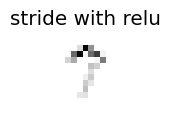

In [92]:
# let's go back to having taken our first convolution with stride 2
show_image(im7_t_top_edge_stride_relu, title='stride with relu')

black is kept, white is dropped


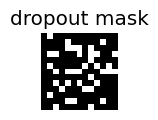

In [124]:
# to use dropout, we initialize a matrix of random weights, choose a threshold, and apply a binary mask:
dropout = torch.rand(im7_t_top_edge_stride_relu.size())
threshold = 0.2
dropout_mask = (dropout > threshold).int()
show_image(dropout_mask, title='dropout mask')
print('black is kept, white is dropped')

<AxesSubplot:title={'center':'stride with relu with dropout'}>

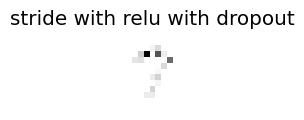

In [126]:
# now instead of applying stride 2 convolution again, we first apply the dropout:

im7_t_top_edge_stride_relu_dropout = im7_t_top_edge_stride_relu * dropout
show_image(im7_t_top_edge_stride_relu_dropout, title='stride with relu with dropout')

kernel applied to entire image: 
 tensor([[   0.0000,    0.6637,   54.4578,  177.8353,    0.5592,    0.0000],
        [   0.0000,  211.9679,   61.1156, -175.4324,  344.7260,    0.0000],
        [   0.0000, -212.6316, -115.5734,   27.9084, -345.2852,    0.0000],
        [   0.0000,    0.0000,    1.0423,   12.1869,    0.0000,    0.0000],
        [   0.0000,    0.0000,  157.0919,   36.0194,    0.0000,    0.0000],
        [   0.0000,    0.0000, -158.1342,  -78.5175,    0.0000,    0.0000]])


<AxesSubplot:title={'center':'layer 1: stride+relu+dropout\nlayer 2: stride+relu'}>

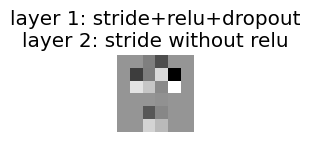

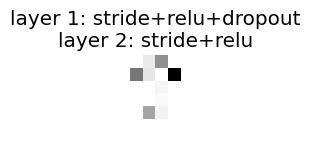

In [129]:
# NOW we apply the convolution with stride 2 a second time
idx = range(1, im7_t_top_edge_stride_relu_dropout.size(0), 2)
im7_t_top_edge_stride_relu_dropout_stride_2 = tensor([[apply_kernel(im7_t_top_edge_stride_relu_dropout, row, col, top_edge) for col in idx] for row in idx])

print('kernel applied to entire image: \n', im7_t_top_edge_stride_relu_dropout_stride_2)
show_image(im7_t_top_edge_stride_relu_dropout_stride_2, title='layer 1: stride+relu+dropout\nlayer 2: stride without relu')

# and finally let's add a minimum with zero - we don't want negative activations.
im7_t_top_edge_stride_relu_dropout_stride_2_relu = F.relu(im7_t_top_edge_stride_relu_dropout_stride_2)
show_image(im7_t_top_edge_stride_relu_dropout_stride_2_relu, title='layer 1: stride+relu+dropout\nlayer 2: stride+relu')